# 보험 응답 예측 모델
https://www.kaggle.com/code/satyaprakashshukl/insurance-boost-analysis/input?select=sample_submission.csv

- **Gender**: 고객의 성별을 나타내는 범주형 변수
- **Age**: 고객의 나이를 나타내는 수치형 변수
- **Driving_License**: 고객의 운전면허 소지 여부를 나타내는 이진 변수 (1: 소지, 0: 미소지)
- **Region_Code**: 고객이 거주하는 지역 코드를 나타내는 수치형 변수
- **Previously_Insured**: 고객의 이전 보험 가입 여부를 나타내는 이진 변수 (1: 가입, 0: 미가입)
- **Vehicle_Age**: 차량의 연식을 나타내는 범주형 변수
- **Vehicle_Damage**: 차량이 과거에 손상된 적이 있는지 여부를 나타내는 범주형 변수
- **Annual_Premium**: 연간 보험료 금액을 나타내는 수치형 변수
- **Policy_Sales_Channel**: 보험 판매 채널을 나타내는 수치형 변수
- **Vintage**: 고객이 회사와 관계를 맺은 일수를 나타내는 수치형 변수
- **Response**: 자동차 보험 제안에 긍정적으로 응답했는지 여부를 나타내는 이진 타겟 변수 (1: 응답, 0: 미응답)


1. **목표**: 자동차 보험 제안에 긍정적으로 응답할 고객을 예측하는 모델을 개발.
   
2. **데이터셋**: `train.csv` (훈련 데이터셋)과 `test.csv` (테스트 데이터셋)를 사용해 `Response` 변수의 확률 예측.
   
3. **기준**: 예측 결과는 **ROC AUC** (Receiver Operating Characteristic - Area Under Curve)로 평가.
   
4. **기타 참고**: Health Insurance Cross Sell Prediction Data의 특성을 기반으로 생성된 데이터로, 원본 데이터셋을 참고하여 모델 성능을 향상시킬 수 있음.

5. **제출 형식**: `sample_submission.csv` 파일과 같은 형식으로 테스트 셋의 각 행에 대한 `Response` 확률을 제출.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import gc


In [ ]:
df_sub=pd.read_csv("/kaggle/input/playground-series-s4e7/sample_submission.csv")
df_train=pd.read_csv("/kaggle/input/lostinpircarhelsep/processed_train_data.csv")
df_test=pd.read_csv("/kaggle/input/lostinpircarhelsep/processed_test_data.csv")

## 데이터 관찰

In [ ]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,1,1,1,35,0,0,1,45512,119,177,0.0
1,1,1,23,1,28,0,2,1,41133,25,278,1.0
2,2,0,5,1,14,1,1,0,21440,144,244,0.0
3,3,0,15,1,1,0,0,1,0,148,66,0.0
4,4,0,16,1,15,1,0,0,15348,144,284,0.0


In [ ]:
df_test.shape,df_train.shape

((7669866, 11), (11504798, 12))

In [ ]:
df_train = df_train.drop(columns=['id'])
df_test = df_test.drop(columns=['id'])

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                int64  
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           int64  
 4   Previously_Insured    int64  
 5   Vehicle_Age           int64  
 6   Vehicle_Damage        int64  
 7   Annual_Premium        int64  
 8   Policy_Sales_Channel  int64  
 9   Vintage               int64  
 10  Response              float64
dtypes: float64(1), int64(10)
memory usage: 965.5 MB


In [ ]:
df_train.describe()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07
mean,5.413510e-01,1.838356e+01,9.980220e-01,2.660494e+01,4.629966e-01,5.215298e-01,5.026798e-01,1.625079e+04,1.069722e+02,1.538977e+02,1.229973e-01
std,4.982872e-01,1.499346e+01,4.443120e-02,1.326433e+01,4.986289e-01,5.767390e-01,4.999928e-01,1.162691e+04,5.116158e+01,7.997953e+01,3.284341e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.000000e+00,1.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,8.675000e+03,2.800000e+01,8.900000e+01,0.000000e+00
50%,1.000000e+00,1.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,0.000000e+00,1.000000e+00,1.522100e+04,1.430000e+02,1.560000e+02,0.000000e+00
75%,1.000000e+00,2.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,1.000000e+00,1.000000e+00,2.284800e+04,1.440000e+02,2.220000e+02,0.000000e+00
max,1.000000e+00,6.500000e+01,1.000000e+00,5.300000e+01,1.000000e+00,2.000000e+00,1.000000e+00,5.395700e+04,1.530000e+02,2.890000e+02,1.000000e+00


# 보험 응답 예측 모델
https://www.kaggle.com/code/satyaprakashshukl/insurance-boost-analysis/input?select=sample_submission.csv

- **Gender**: 고객의 성별을 나타내는 범주형 변수
- **Age**: 고객의 나이를 나타내는 수치형 변수
- **Driving_License**: 고객의 운전면허 소지 여부를 나타내는 이진 변수 (1: 소지, 0: 미소지)
- **Region_Code**: 고객이 거주하는 지역 코드를 나타내는 수치형 변수
- **Previously_Insured**: 고객의 이전 보험 가입 여부를 나타내는 이진 변수 (1: 가입, 0: 미가입)
- **Vehicle_Age**: 차량의 연식을 나타내는 범주형 변수
- **Vehicle_Damage**: 차량이 과거에 손상된 적이 있는지 여부를 나타내는 범주형 변수
- **Annual_Premium**: 연간 보험료 금액을 나타내는 수치형 변수
- **Policy_Sales_Channel**: 보험 판매 채널을 나타내는 수치형 변수
- **Vintage**: 고객이 회사와 관계를 맺은 일수를 나타내는 수치형 변수
- **Response**: 자동차 보험 제안에 긍정적으로 응답했는지 여부를 나타내는 이진 타겟 변수 (1: 응답, 0: 미응답)


1. **목표**: 자동차 보험 제안에 긍정적으로 응답할 고객을 예측하는 모델을 개발.
   
2. **데이터셋**: `train.csv` (훈련 데이터셋)과 `test.csv` (테스트 데이터셋)를 사용해 `Response` 변수의 확률 예측.
   
3. **기준**: 예측 결과는 **ROC AUC** (Receiver Operating Characteristic - Area Under Curve)로 평가.
   
4. **기타 참고**: Health Insurance Cross Sell Prediction Data의 특성을 기반으로 생성된 데이터로, 원본 데이터셋을 참고하여 모델 성능을 향상시킬 수 있음.

5. **제출 형식**: `sample_submission.csv` 파일과 같은 형식으로 테스트 셋의 각 행에 대한 `Response` 확률을 제출.

## EDA

In [ ]:
import seaborn as sns

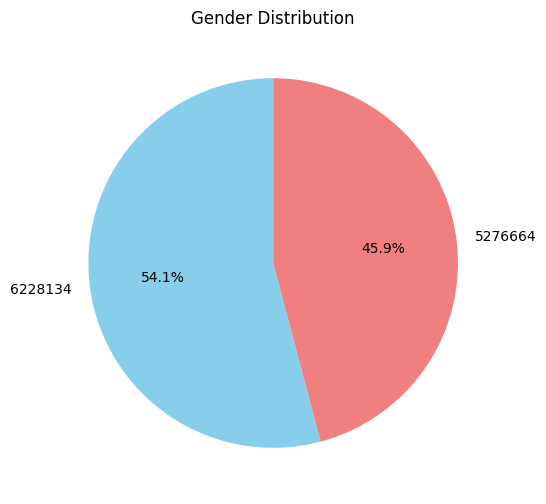

In [ ]:
gender_counts = df_train['Gender'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], startangle=90)
plt.title('Gender Distribution')
plt.show()

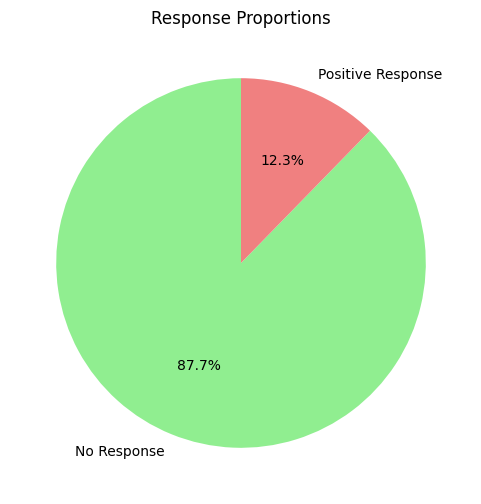

In [ ]:
response_counts = df_train['Response'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(response_counts, labels=['No Response', 'Positive Response'], autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'], startangle=90)
plt.title('Response Proportions')
plt.show()

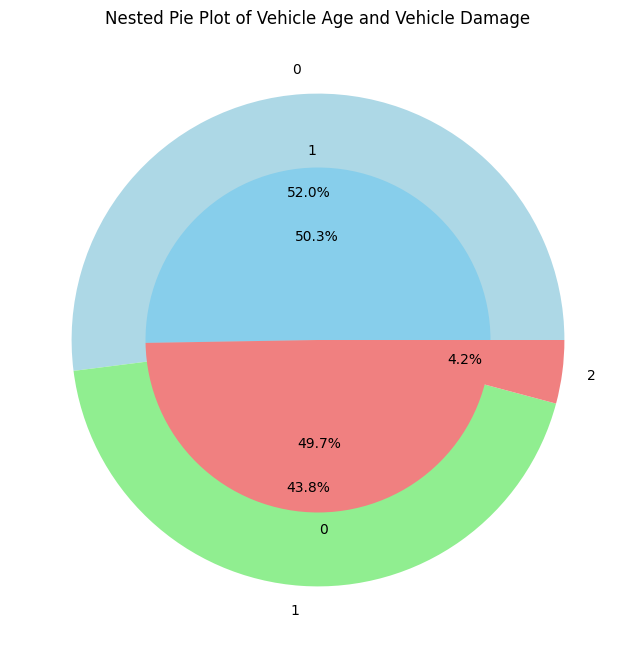

In [ ]:
vehicle_age_counts = df_train['Vehicle_Age'].value_counts()
vehicle_damage_counts = df_train['Vehicle_Damage'].value_counts()

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(vehicle_age_counts, labels=vehicle_age_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'lightcoral'], radius=1)
ax.pie(vehicle_damage_counts, labels=vehicle_damage_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], radius=0.7)
ax.set(aspect="equal", title='Nested Pie Plot of Vehicle Age and Vehicle Damage')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


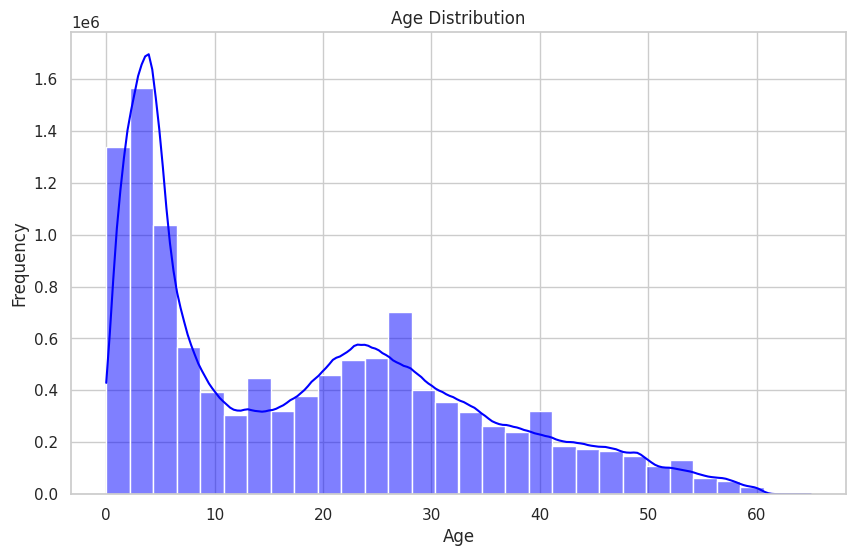

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(df_train['Age'], bins=30, kde=True, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

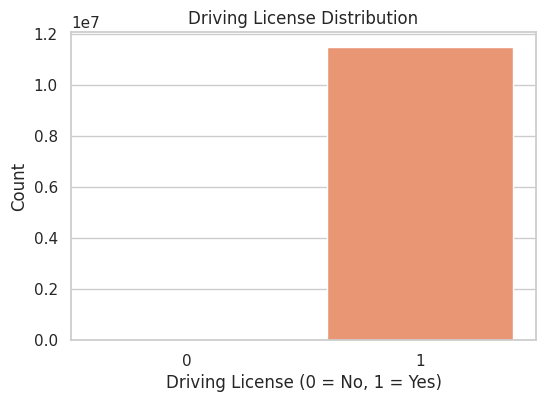

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Driving_License', data=df_train, palette='Set2')
plt.title('Driving License Distribution')
plt.xlabel('Driving License (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


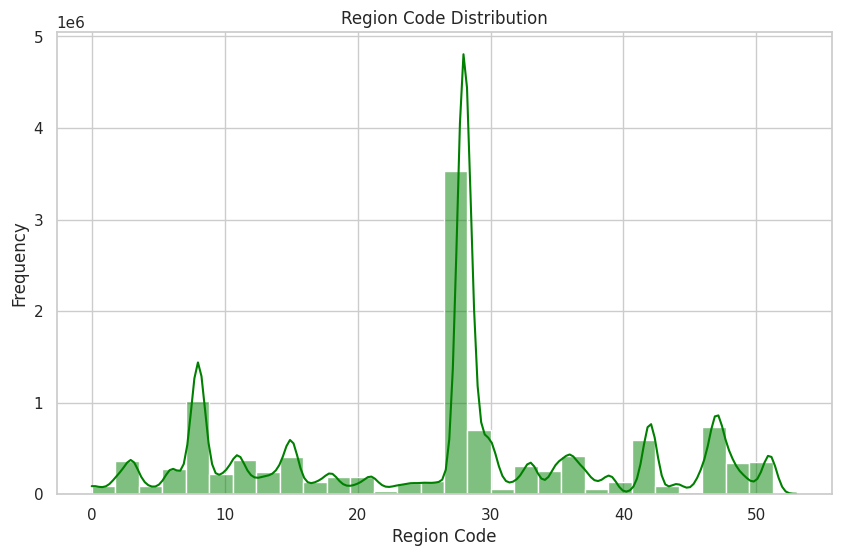

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train['Region_Code'], bins=30, kde=True, color='green')
plt.title('Region Code Distribution')
plt.xlabel('Region Code')
plt.ylabel('Frequency')
plt.show()

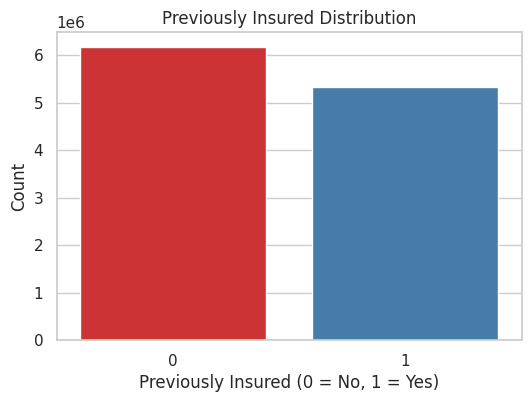

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Previously_Insured', data=df_train, palette='Set1')
plt.title('Previously Insured Distribution')
plt.xlabel('Previously Insured (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


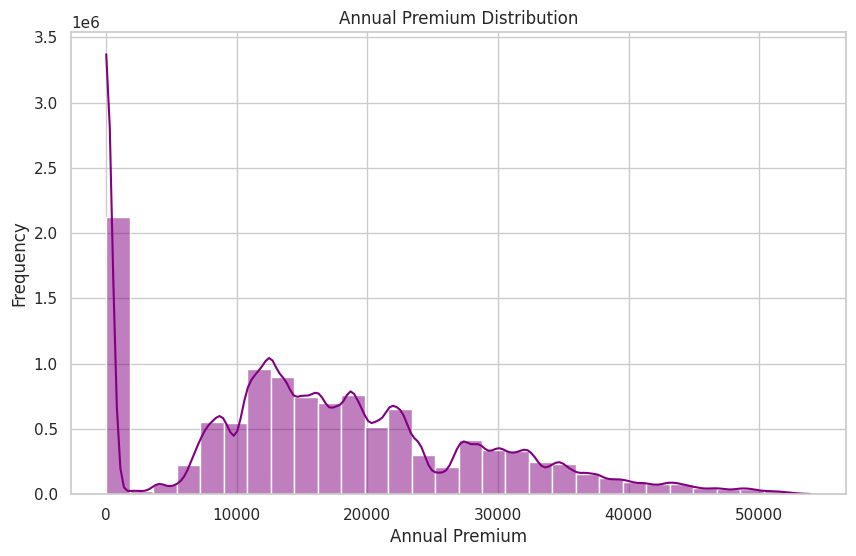

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train['Annual_Premium'], bins=30, kde=True, color='purple')
plt.title('Annual Premium Distribution')
plt.xlabel('Annual Premium')
plt.ylabel('Frequency')
plt.show()

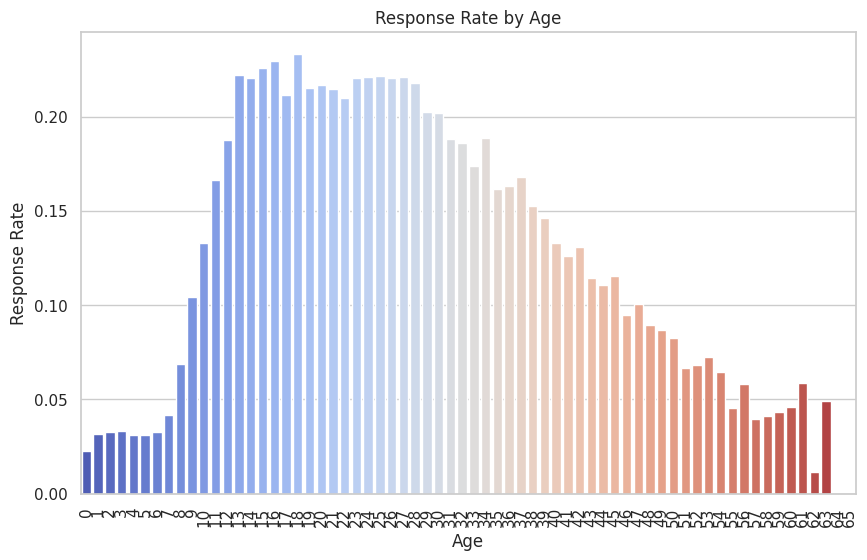

In [ ]:
plt.figure(figsize=(10, 6))
age_response = df_train.groupby('Age')['Response'].mean().reset_index()
sns.barplot(x='Age', y='Response', data=age_response, palette='coolwarm')
plt.title('Response Rate by Age')
plt.xlabel('Age')
plt.ylabel('Response Rate')
plt.xticks(rotation=90)
plt.show()

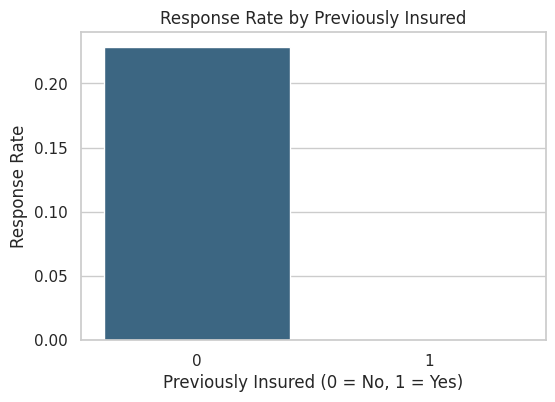

In [ ]:

plt.figure(figsize=(6, 4))
insured_response = df_train.groupby('Previously_Insured')['Response'].mean().reset_index()
sns.barplot(x='Previously_Insured', y='Response', data=insured_response, palette='viridis')
plt.title('Response Rate by Previously Insured')
plt.xlabel('Previously Insured (0 = No, 1 = Yes)')
plt.ylabel('Response Rate')
plt.show()

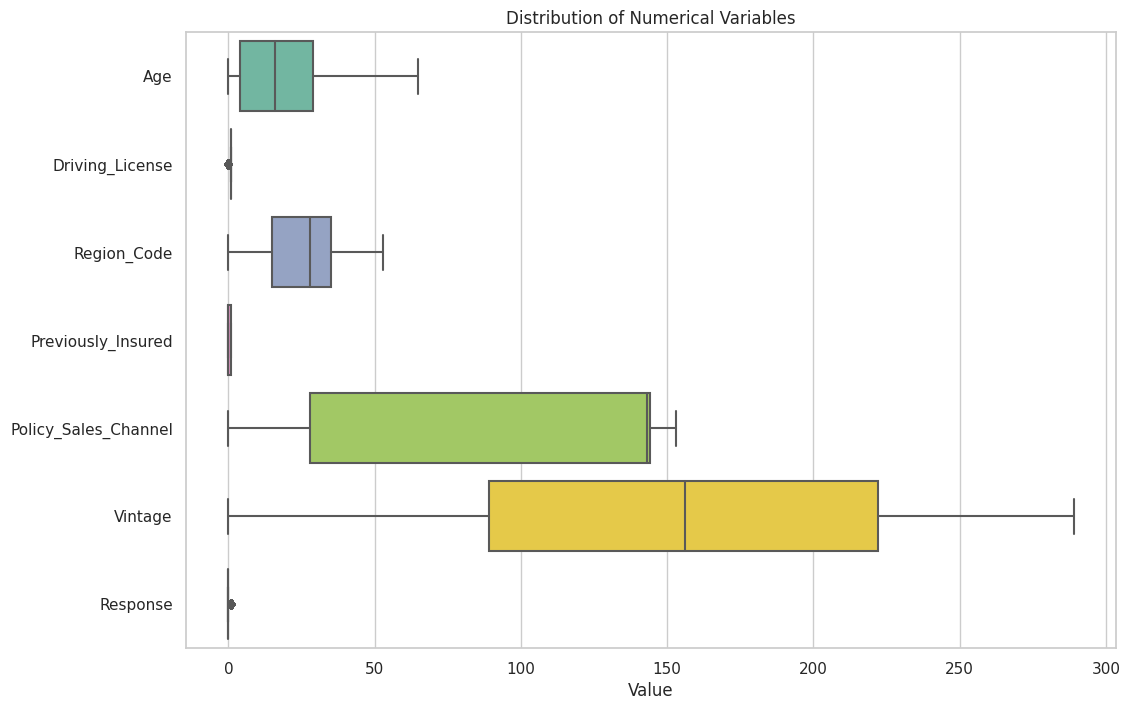

In [ ]:
numerical_cols = ['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
                  'Policy_Sales_Channel', 'Vintage', 'Response']
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_train[numerical_cols], orient='h', palette='Set2')
plt.title('Distribution of Numerical Variables')
plt.xlabel('Value')
plt.show()

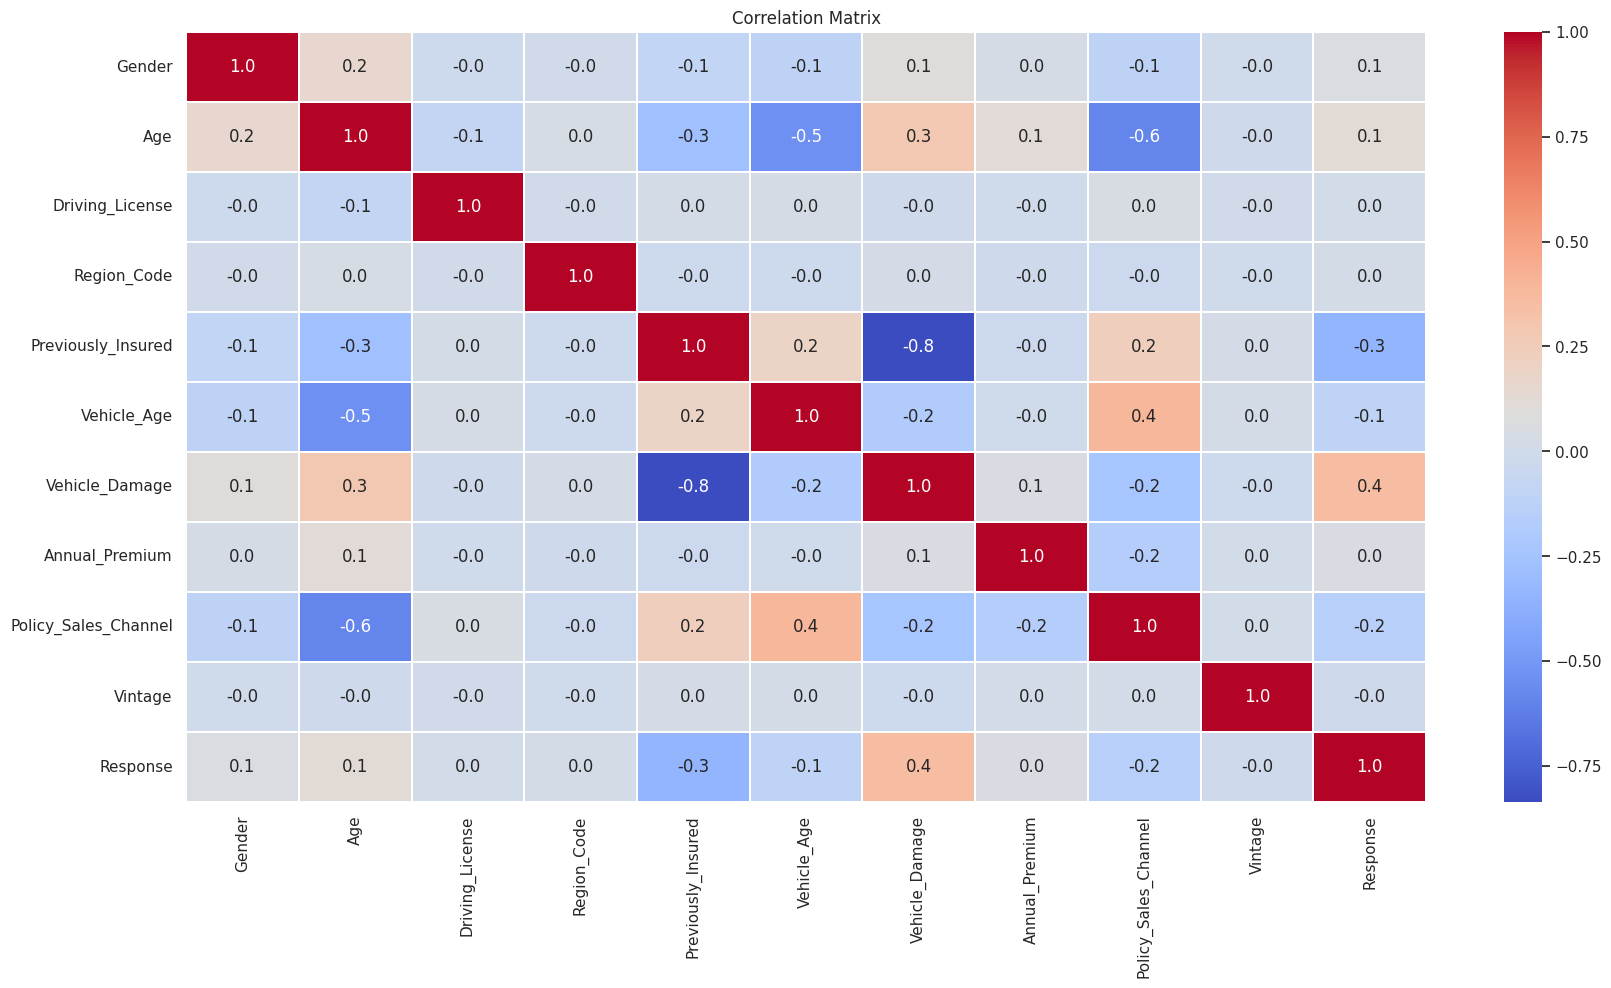

In [ ]:
correlation_matrix = df_train.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.1)
#plt.gcf().set_facecolor('skyblue')
plt.title('Correlation Matrix')
plt.show()

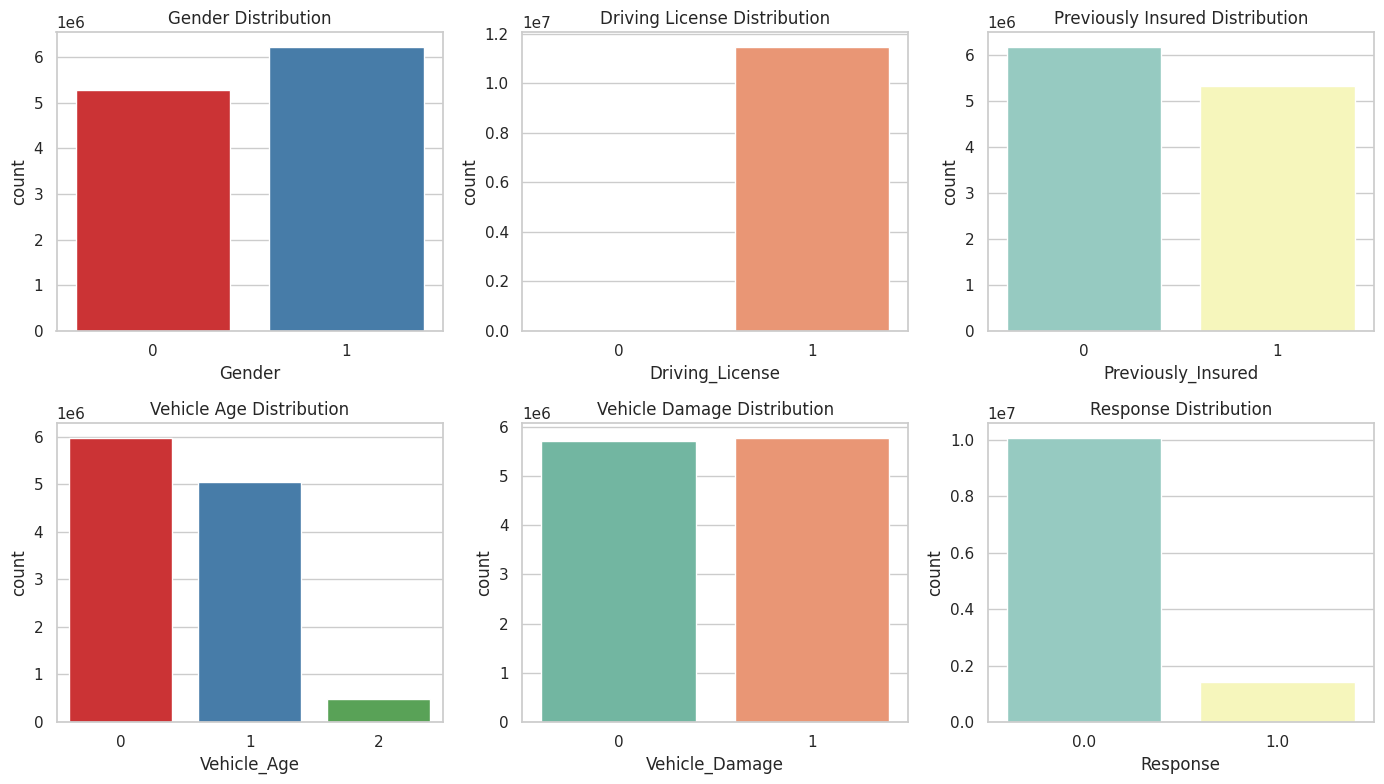

In [ ]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 3, 1)
sns.countplot(x='Gender', data=df_train, palette='Set1')
plt.title('Gender Distribution')

plt.subplot(2, 3, 2)
sns.countplot(x='Driving_License', data=df_train, palette='Set2')
plt.title('Driving License Distribution')

plt.subplot(2, 3, 3)
sns.countplot(x='Previously_Insured', data=df_train, palette='Set3')
plt.title('Previously Insured Distribution')

plt.subplot(2, 3, 4)
sns.countplot(x='Vehicle_Age', data=df_train, palette='Set1')
plt.title('Vehicle Age Distribution')

plt.subplot(2, 3, 5)
sns.countplot(x='Vehicle_Damage', data=df_train, palette='Set2')
plt.title('Vehicle Damage Distribution')

plt.subplot(2, 3, 6)
sns.countplot(x='Response', data=df_train, palette='Set3')
plt.title('Response Distribution')

plt.tight_layout()
plt.show()

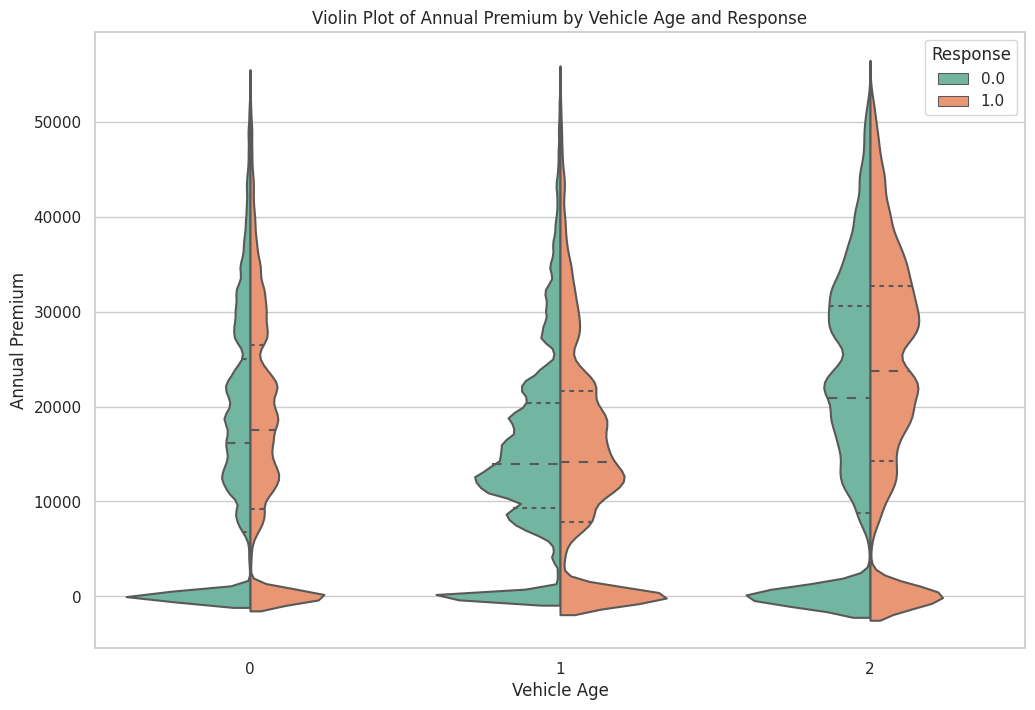

In [ ]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='Vehicle_Age', y='Annual_Premium', data=df_train, hue='Response', split=True, palette='Set2', inner='quartile')
plt.title('Violin Plot of Annual Premium by Vehicle Age and Response')
plt.xlabel('Vehicle Age')
plt.ylabel('Annual Premium')
plt.show()

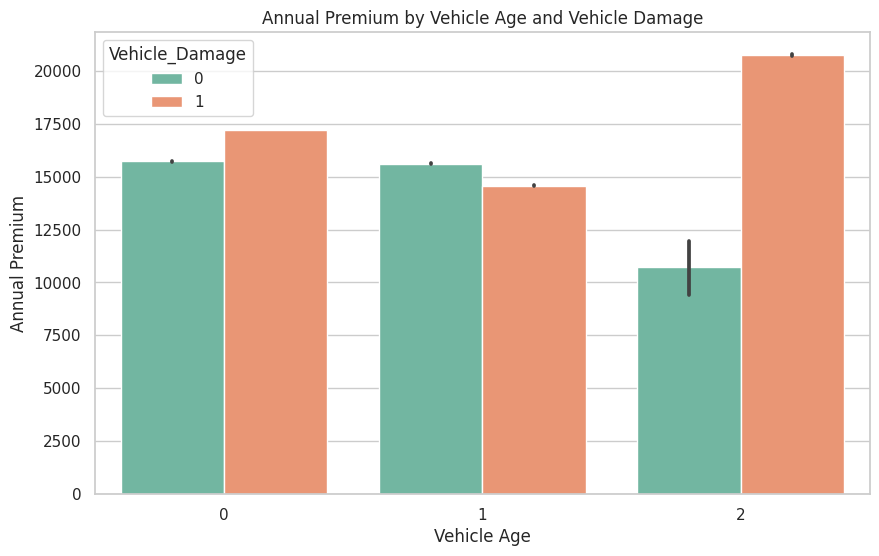

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Vehicle_Age', y='Annual_Premium', hue='Vehicle_Damage', data=df_train, palette='Set2')
plt.title('Annual Premium by Vehicle Age and Vehicle Damage')
plt.xlabel('Vehicle Age')
plt.ylabel('Annual Premium')
plt.show()

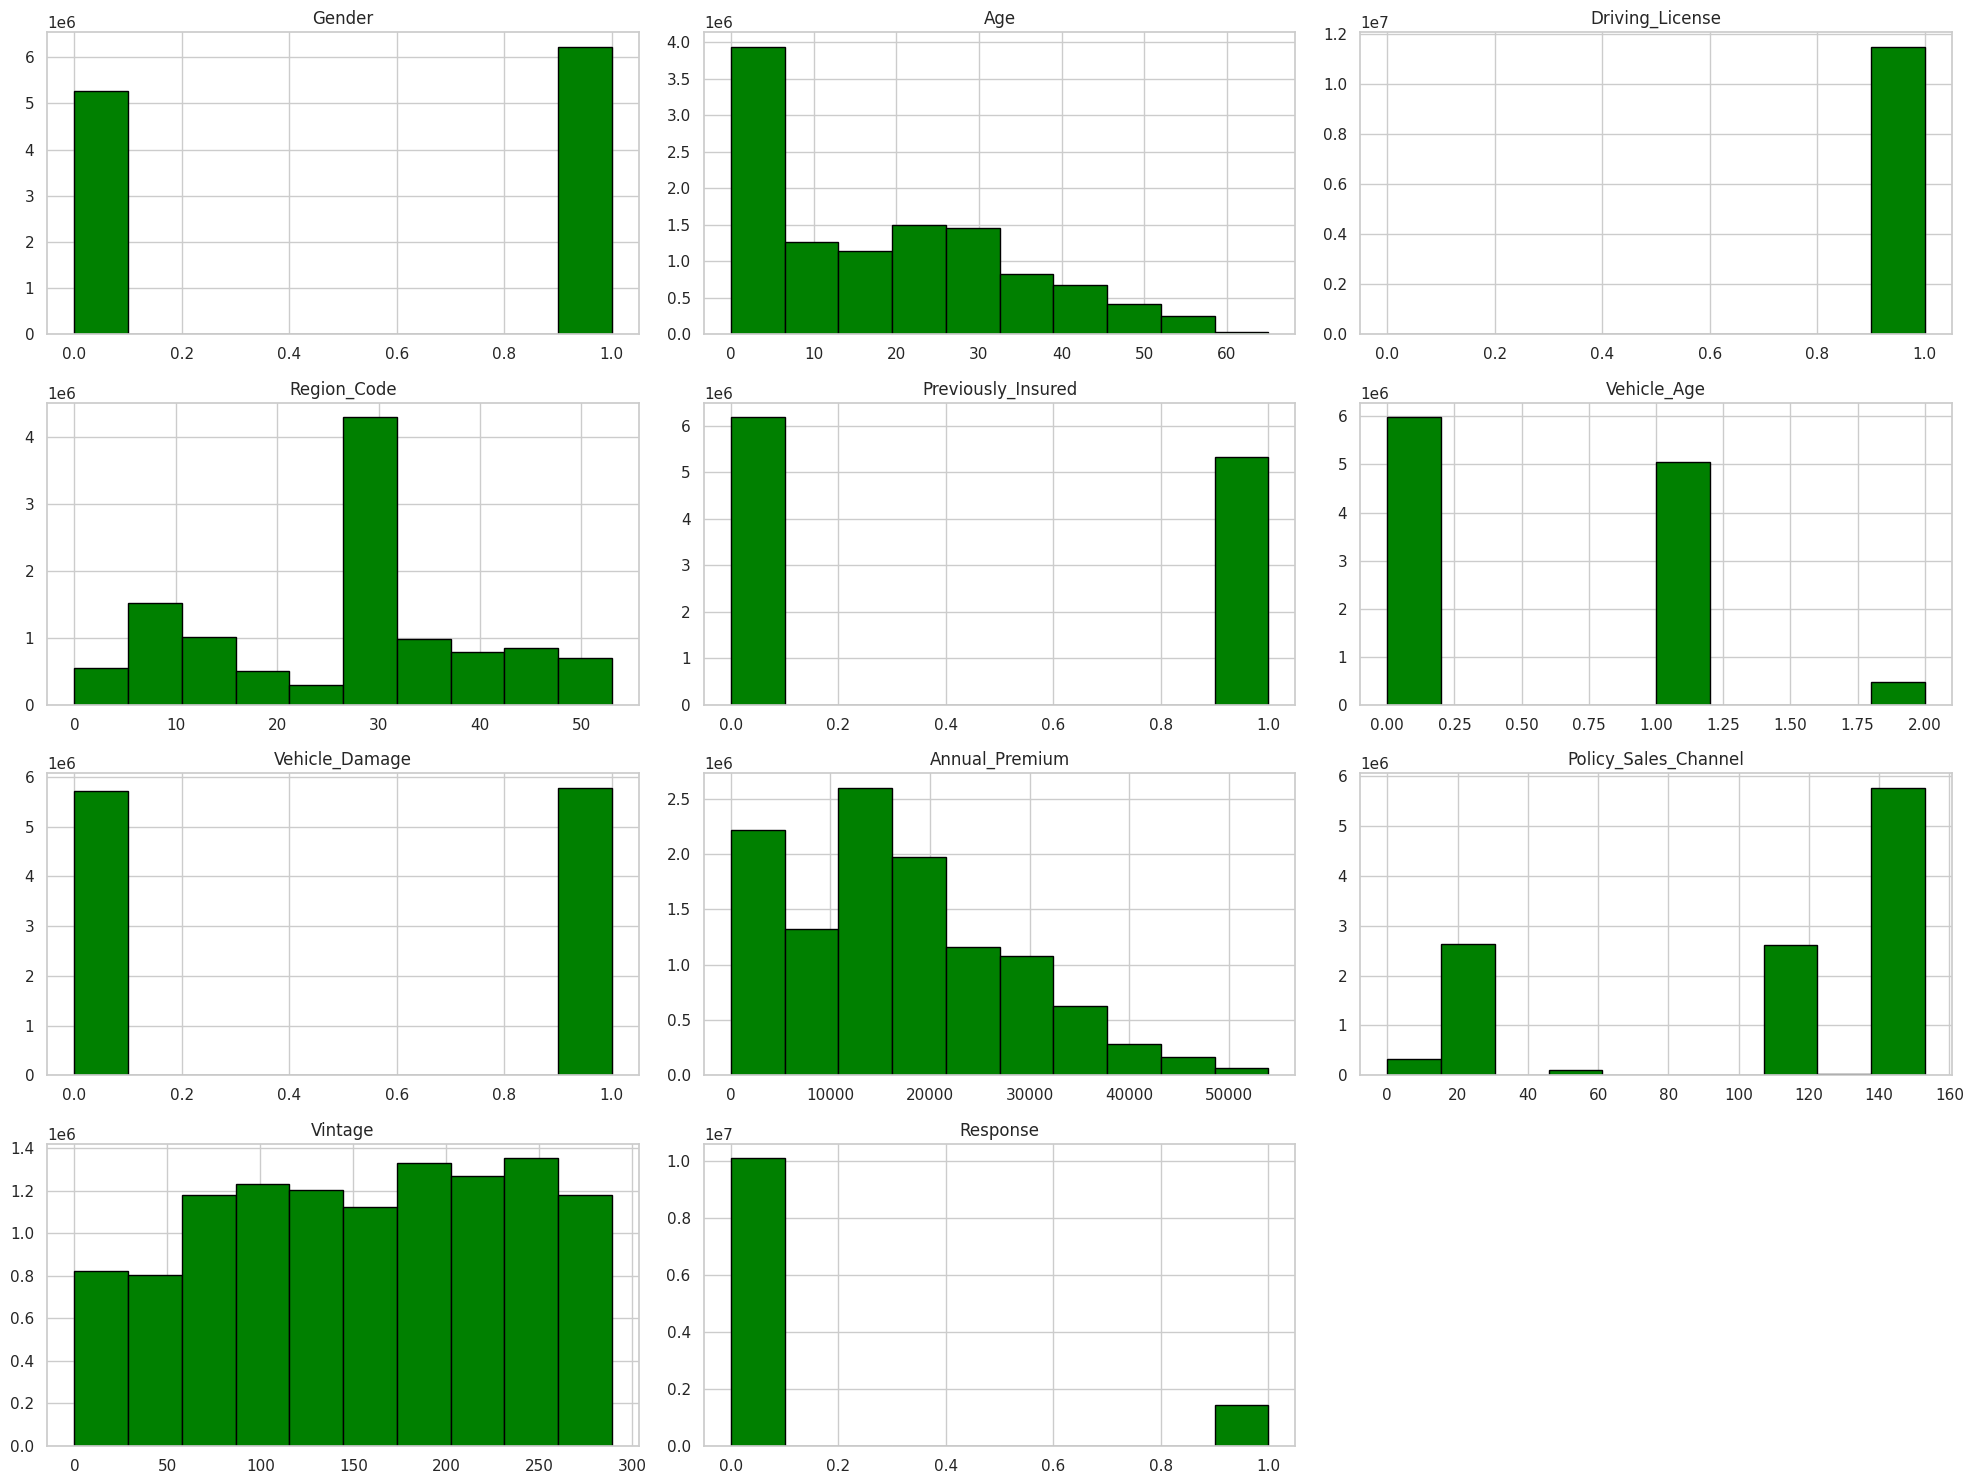

In [ ]:
df_train.hist(figsize=(20, 15), color='green', edgecolor='black')
plt.gcf().set_facecolor('white')
plt.tight_layout()
plt.show()

In [ ]:
def feature_engineering(df):

    df['Age_Vehicle_Age'] = df['Age'] * df['Vehicle_Age']
    df['Age_Previously_Insured'] = df['Age'] * df['Previously_Insured']
    df['Vehicle_Age_Damage'] = df['Vehicle_Age'] * df['Vehicle_Damage']
    df['Previously_Insured_Damage'] = df['Previously_Insured'] * df['Vehicle_Damage']
    df['Age_squared'] = df['Age'] ** 2
    df['Vehicle_Age_squared'] = df['Vehicle_Age'] ** 2
    df['Annual_Premium_per_Age'] = df['Annual_Premium'] / (df['Age'] + 1)
    return df

#df_train = feature_engineering(df_train)
#df_test = feature_engineering(df_test)

In [ ]:
df_train.dtypes

Gender                    int64
Age                       int64
Driving_License           int64
Region_Code               int64
Previously_Insured        int64
Vehicle_Age               int64
Vehicle_Damage            int64
Annual_Premium            int64
Policy_Sales_Channel      int64
Vintage                   int64
Response                float64
dtype: object

In [ ]:
df_test.dtypes

Gender                  int64
Age                     int64
Driving_License         int64
Region_Code             int64
Previously_Insured      int64
Vehicle_Age             int64
Vehicle_Damage          int64
Annual_Premium          int64
Policy_Sales_Channel    int64
Vintage                 int64
dtype: object

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #7FFFD4; font-size:100%; text-align:left">

<h3 align="center"><font color='#DAA520'>💡 Observation from above plot :</font></h3>
    
**Age vs. Vehicle_Age**:
There is a strong negative correlation (-0.5377), indicating that as age increases, the age of the vehicle tends to decrease. This makes sense as older individuals may prefer newer vehicles.
    
**Previously_Insured vs. Vehicle_Damage:**
There is a strong negative correlation (-0.8362), suggesting that individuals who have not previously been insured are more likely to have vehicle damage. This makes intuitive sense since insured individuals might be more cautious about vehicle maintenance.
    
**Policy_Sales_Channel vs. Channel_Vintage:**
There is a strong positive correlation (0.6673), indicating that certain policy sales channels are associated with longer customer vintage. This suggests that specific sales channels are successful in retaining customers over time.
    
**Previously_Insured vs. Response:**
There is a moderate negative correlation (-0.3459), indicating that individuals who are previously insured are less likely to respond positively to insurance offers. This could be due to perceived redundancy or satisfaction with current coverage.
    
**Vehicle_Damage vs. Response:**
There is a moderate positive correlation (0.3598), suggesting that individuals with vehicle damage are more likely to respond positively to insurance offers. This implies that damaged vehicles might prompt individuals to seek additional or improved insurance coverage.

In [ ]:
y = df_train['Response']
X = df_train.drop(['Response'],axis=1)

## 모델학습

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y,test_size = 0.2, random_state =42)

In [ ]:
train_X = train_X.to_numpy()
train_y = train_y.to_numpy()
test_X = test_X.to_numpy()
test_y = test_y.to_numpy()

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score


params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.03,  # Reduced learning rate
    'alpha': 0.1,  # Slightly reduced regularization
    'subsample': 0.851,  # Increased subsample fraction
    'colsample_bytree': 0.45,  # Adjusted colsample_bytree
    'max_depth': 12,  # Reduced max depth
    'min_child_weight': 10,  # Slightly increased to control overfitting
    'gamma': 1e-6,  # Slightly increased gamma
    'random_state': 42,
    'max_bin': 100,  # Reduced max_bin from 50000
    'enable_categorical': True,
    'n_estimators': 100,  # Keep high for early stopping
    'tree_method': 'hist',
    'early_stopping_rounds':50,
    'verbose':50
}
gc.collect()
model = XGBClassifier(**params,device="cuda")
XGB = model.fit(
    train_X,
    train_y,
    eval_set=[(test_X, test_y)]
)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:18:39] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:18:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-auc:0.72032
[1]	validation_0-auc:0.75529
[2]	validation_0-auc:0.75371
[3]	validation_0-auc:0.76482
[4]	validation_0-auc:0.83212
[5]	validation_0-auc:0.84377
[6]	validation_0-auc:0.84831
[7]	validation_0-auc:0.85295
[8]	validation_0-auc:0.85548
[9]	validation_0-auc:0.85641
[10]	validation_0-auc:0.85825
[11]	validation_0-auc:0.86071
[12]	validation_0-auc:0.85947
[13]	validation_0-auc:0.86112
[14]	validation_0-auc:0.86262
[15]	validation_0-auc:0.86375
[16]	validation_0-auc:0.86405
[17]	validation_0-auc:0.86355
[18]	validation_0-auc:0.86264
[19]	validation_0-auc:0.86313
[20]	validation_0-auc:0.86420
[21]	validation_0-auc:0.86464
[22]	validation_0-auc:0.86477
[23]	validation_0-auc:0.86495
[24]	validation_0-auc:0.86544
[25]	validation_0-auc:0.86570
[26]	validation_0-auc:0.86541
[27]	validation_0-auc:0.86563
[28]	validation_0-auc:0.86529
[29]	validation_0-auc:0.86526
[30]	validation_0-auc:0.86565
[31]	validation_0-auc:0.86604
[32]	validation_0-auc:0.86620
[33]	validation_0-au

In [ ]:
prediction = XGB.predict(test_X)


In [ ]:
print("Best iteration:", model.best_iteration)

Best iteration: 97


In [ ]:
val_pred_prob = XGB.predict_proba(test_X)[:, 1]
auc = roc_auc_score(test_y, val_pred_prob)
print(f"Validation AUC: {auc:.5f}")

Validation AUC: 0.86987


In [ ]:
df_test = df_test.to_numpy()

In [ ]:
test_pred_prob = XGB.predict_proba(df_test)[:, 1]

In [ ]:
df_sub.Response= test_pred_prob

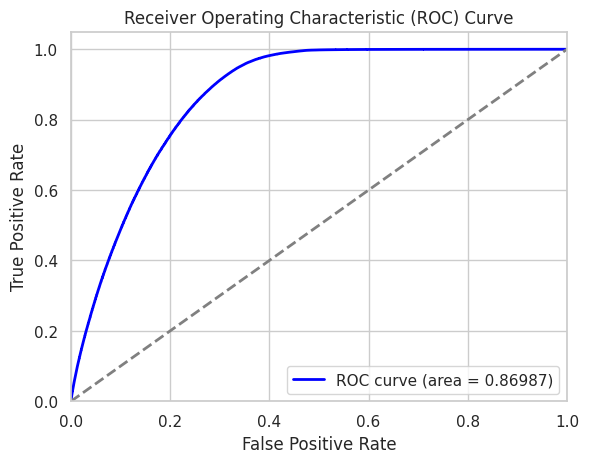

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(test_y, val_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.5f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

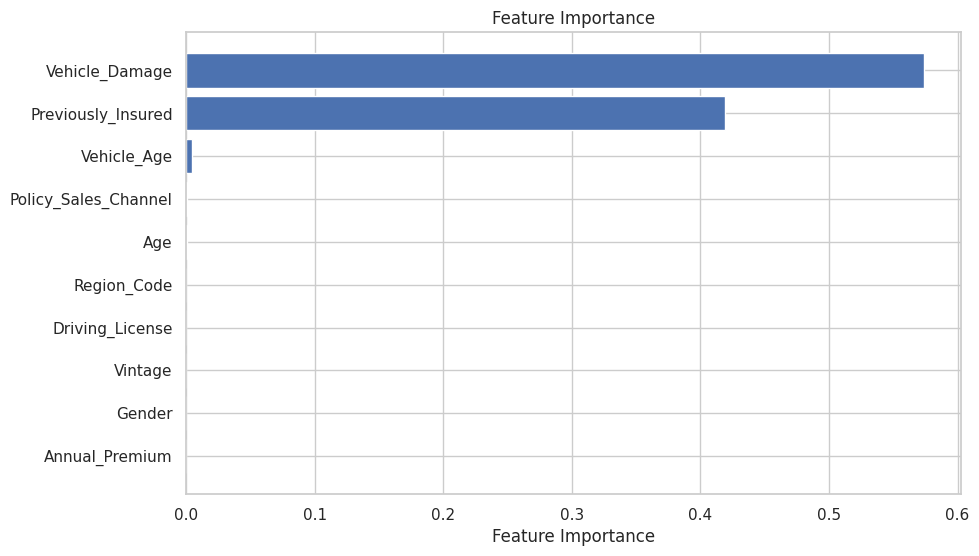

In [ ]:
plt.figure(figsize=(10, 6))
importance = model.feature_importances_
sorted_idx = np.argsort(importance)
plt.barh(range(len(importance)), importance[sorted_idx], align='center')
plt.yticks(range(len(importance)), [df_train.columns[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, confusion_matrix, precision_recall_curve, average_precision_score


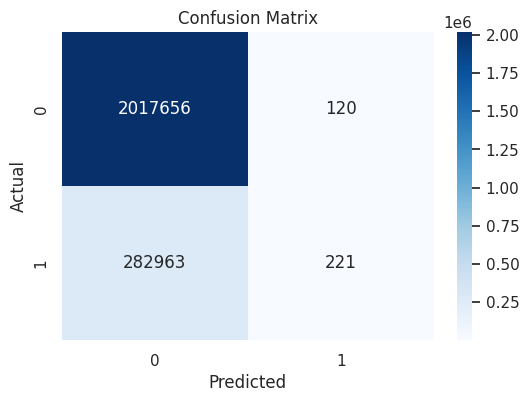

In [ ]:
#val_pred = XGB.predict(val_X)
cm = confusion_matrix(test_y, prediction)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Confusion Matrix를 보면 올바른 예측은 87~88%임을 확인할 수 있음

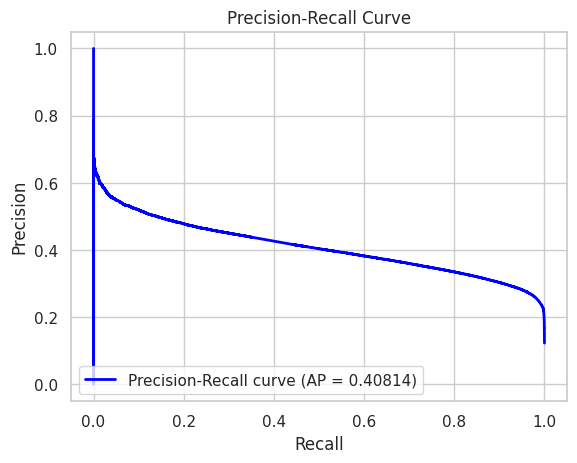

In [ ]:
precision, recall, _ = precision_recall_curve(test_y, val_pred_prob)
average_precision = average_precision_score(test_y, val_pred_prob)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.5f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()